In [4]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [6]:
def filterDataset(ann_path, classes):    
    # initialize COCO api for instance annotations
    annFile = ann_path
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [7]:
train_ann_path = r"D:\Nirwan\PANet\foo-upgraded\coco\annotations\instances_train2014.json"
val_ann_path = r"D:\Nirwan\PANet\foo-upgraded\coco\annotations\instances_val2014.json"

In [8]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size=(224, 224)):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        print(coco.annToMask(anns[a]))
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mask_type='binary'):
    
    img_folder = '{}'.format(folder)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            #print(imageObj)
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        
        assert not np.any(np.isnan(img))
        assert not np.any(np.isnan(mask))
        
        yield img, mask/255

In [9]:
classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [20]:
classes = ['storage_tank', 'Large_Vehicle', 'Small_Vehicle','plane','ship','Swimming_pool','Harbor', 'tennis_court', 'Ground_Track_Field', 'Soccer_ball_field', 'baseball_diamond', 'Bridge', 'basketball_court', 'Roundabout', 'Helicopter']

In [10]:
#train_images, train_dataset_size, train_coco = filterDataset(train_ann_path, classes,)
val_images, val_dataset_size, val_coco = filterDataset(val_ann_path, classes,)

loading annotations into memory...
Done (t=7.42s)
creating index...
index created!


In [14]:
batch_size = 4
input_image_size = (256,256)
mask_type = 'normal'

train_img_folder = r'D:\Nirwan\PANet\foo-upgraded\coco\train2014'
val_img_folder = r'D:\Nirwan\PANet\foo-upgraded\coco\val2014'

#train_gen = dataGeneratorCoco(train_images, classes, train_coco, train_img_folder,
 #                           input_image_size, batch_size, mask_type)
val_gen = dataGeneratorCoco(val_images, classes, val_coco, val_img_folder,
                            input_image_size, batch_size, mask_type)

In [15]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [

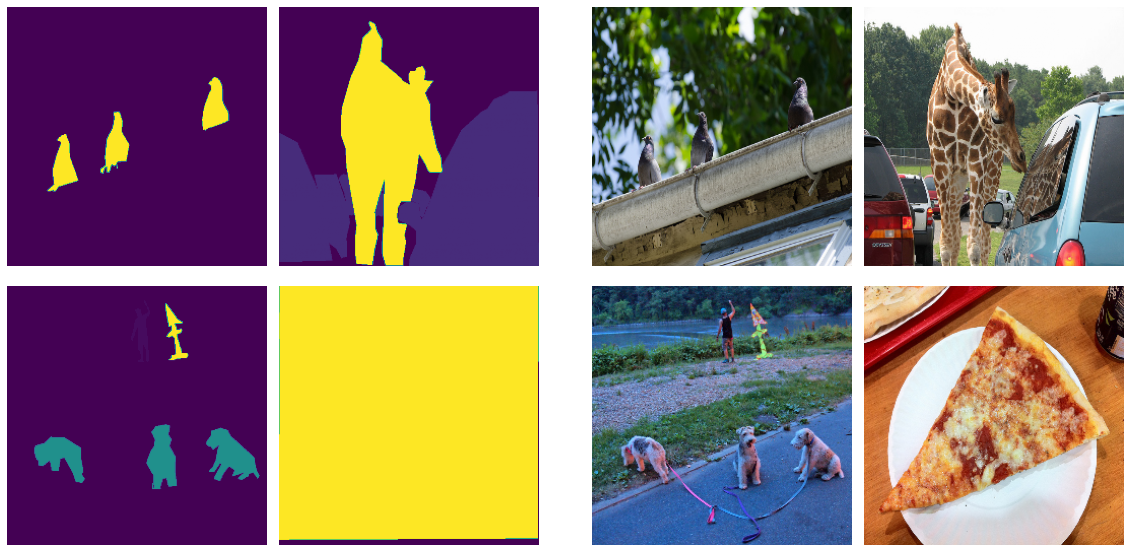

In [16]:
visualizeGenerator(val_gen)

In [23]:
n_epochs = 20
steps_per_epoch = train_dataset_size // batch_size
validation_steps = val_dataset_size // batch_size

In [19]:
import segmentation_models as sm
from tensorflow import keras

In [30]:
model = sm.Unet('efficientnetb7', classes=80, activation='sigmoid')

In [31]:
optim = keras.optimizers.Adam(0.0001)
dice_loss = sm.losses.DiceLoss(class_weights=np.ones(80)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [32]:
model.compile(optim, total_loss, metrics)

In [33]:
checkpoint_dir = './training_checkpoints/coco'
        # Define the name of the checkpoint files.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [34]:
callbacks = [
        keras.callbacks.TensorBoard(log_dir='./semantic_logs'),
        keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, verbose=0,
                                            save_weights_only=True),
        keras.callbacks.EarlyStopping(monitor="val_loss",
                                            min_delta=0.001,
                                            patience=10,
                                            verbose=1,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True),
    ]

In [35]:
history = model.fit(x=train_gen, validation_data=val_gen, epochs=100, steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps, verbose=True, callbacks=callbacks)

Epoch 1/100
20409/20409 [==============================] - 6553s 319ms/step - loss: 0.8363 - iou_score: 0.1054 - f1-score: 0.1851 - val_loss: 0.8162 - val_iou_score: 0.1132 - val_f1-score: 0.1978
Epoch 2/100
20409/20409 [==============================] - 6524s 320ms/step - loss: 0.8147 - iou_score: 0.1176 - f1-score: 0.2047 - val_loss: 0.8131 - val_iou_score: 0.1162 - val_f1-score: 0.2019
Epoch 3/100
20409/20409 [==============================] - 6514s 319ms/step - loss: 0.8076 - iou_score: 0.1219 - f1-score: 0.2115 - val_loss: 0.8136 - val_iou_score: 0.1145 - val_f1-score: 0.1999
Epoch 4/100
20409/20409 [==============================] - 6539s 320ms/step - loss: 0.8016 - iou_score: 0.1255 - f1-score: 0.2171 - val_loss: 0.8102 - val_iou_score: 0.1177 - val_f1-score: 0.2040
Epoch 5/100
20409/20409 [==============================] - 6456s 316ms/step - loss: 0.7978 - iou_score: 0.1277 - f1-score: 0.2207 - val_loss: 0.8113 - val_iou_score: 0.1176 - val_f1-score: 0.2037
Epoch 6/100
20409/20

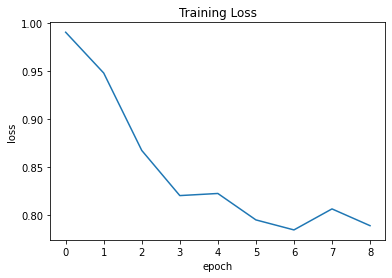

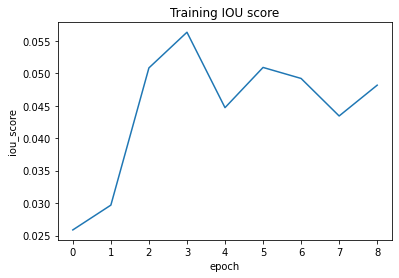

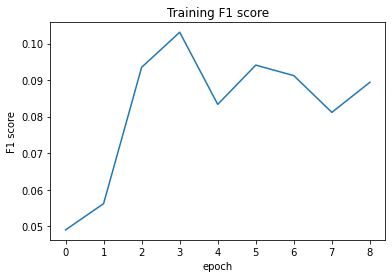

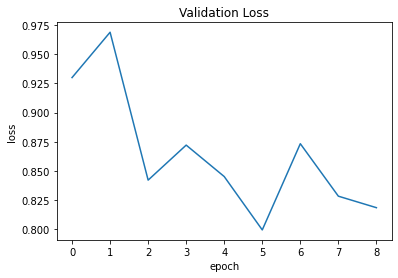

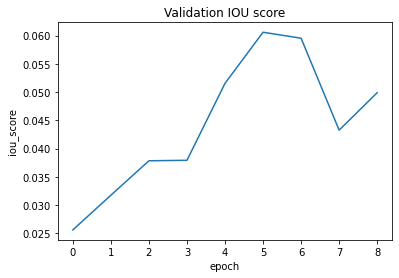

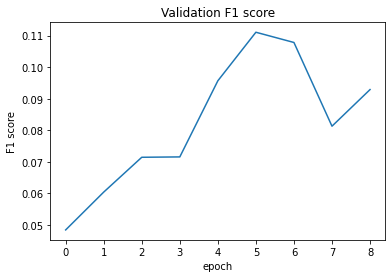

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["iou_score"])
plt.title("Training IOU score")
plt.ylabel("iou_score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["f1-score"])
plt.title("Training F1 score")
plt.ylabel("F1 score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_iou_score"])
plt.title("Validation IOU score")
plt.ylabel("iou_score")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_f1-score"])
plt.title("Validation F1 score")
plt.ylabel("F1 score")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.save("coco_sem_seg_model.h5")

In [1]:
import tensorflow as tf
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [2]:
model = sm.Unet('efficientnetb7', classes=80, activation='sigmoid')

In [3]:
model.load_weights("coco_sem_seg_model.h5")

In [20]:
optim = keras.optimizers.Adam(0.0001)
dice_loss = sm.losses.DiceLoss(class_weights=np.ones(80)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [21]:
model.compile(optim, total_loss, metrics)

In [22]:
model.evaluate(val_gen, batch_size=4)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [